<a href="https://colab.research.google.com/github/Austfi/SNOWPACKforPatrollers/blob/dev/RF_Instability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RF Snow Instability Analysis - Modern Model

This notebook analyzes SNOWPACK PRO files using the Random Forest instability model from the `sarp.snowprofile.pyface` CRAN package. It automatically selects a version-compatible pickle file based on your installed scikit-learn version.

## Features

- **Automatic model selection**: Downloads and selects the best RF model pickle for your scikit-learn version
- **Single profile analysis**: Analyze a specific timestamp from a PRO file
- **Seasonal evolution**: Track instability probabilities over time
- **CSV export**: Export daily instability metrics for further analysis

## Requirements

This notebook requires Python helper modules (`readProfile`, `get_RF`, `plt_RF`) that read SNOWPACK PRO files compatible with the [sarp.snowprofile R package](https://cran.r-project.org/web/packages/sarp.snowprofile/refman/sarp.snowprofile.html#snowprofilePro) PRO file format specification.

## RF Snow Instability — Modern Model (Auto-select for scikit-learn)

This add-on fetches updated, version-compatible RF pickles from the sarp.snowprofile.pyface CRAN source tarball. It auto-selects a model based on your installed scikit-learn version so you can keep the environment modern without manual pickle surgery.

**Note**: This section uses Python helper modules (`readProfile`, `get_RF`, `plt_RF`) that read SNOWPACK PRO files compatible with the [sarp.snowprofile R package](https://cran.r-project.org/web/packages/sarp.snowprofile/refman/sarp.snowprofile.html#snowprofilePro) PRO file format specification. The `remove_soil` parameter behavior matches the R package default.

- `slopeangle` only tunes the MF-crust penetration-depth logic.
- `P_unstable` reports the layer-wise instability probability rather than a direct hazard rating.
- Run these cells sequentially; they create an isolated `rf_instability_modern` folder and leave existing workflow cells unchanged.


In [28]:
# RF modern: environment report (read-only)
import sys, platform

try:
    import sklearn
    print("Python:", sys.version)
    print("Platform:", platform.platform())
    print("scikit-learn:", sklearn.__version__)
except Exception as rf_env_err:
    print("Environment introspection warning:", rf_env_err)


Python: 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:28:27) [Clang 14.0.6 ]
Platform: macOS-10.16-x86_64-i386-64bit
scikit-learn: 1.5.1


In [29]:
# RF modern: paths & sys.path guard
import sys, pathlib, datetime

rf_nb_dir = pathlib.Path.cwd()
rf_mod_dir = (rf_nb_dir / "rf_instability_modern").resolve()
rf_mod_dir.mkdir(parents=True, exist_ok=True)

if str(rf_mod_dir) not in sys.path:
    sys.path.insert(0, str(rf_mod_dir))

rf_nb_name = "SNOWPACKforPatrollers.ipynb"
rf_backup_prefix = "SNOWPACKforPAtrollers.backup."
rf_existing_backups = sorted(rf_nb_dir.glob(f"{rf_backup_prefix}*.ipynb"))

if rf_existing_backups:
    print("Backup previously detected:", rf_existing_backups[-1].name)
else:
    rf_backup_name = f"{rf_backup_prefix}{datetime.datetime.now():%Y%m%d-%H%M}.ipynb"
    if (rf_nb_dir / rf_nb_name).exists():
        try:
            (rf_nb_dir / rf_backup_name).write_bytes((rf_nb_dir / rf_nb_name).read_bytes())
            print("Backup written:", rf_backup_name)
        except Exception as rf_backup_err:
            print("Backup warning:", rf_backup_err)
    else:
        print("Notebook not found for backup:", rf_nb_name)

print("RF modern dir:", rf_mod_dir)


Backup previously detected: SNOWPACKforPAtrollers.backup.20251103-2018.ipynb
RF modern dir: /Users/austinfinnell/Documents/GitHub/SNOWPACKforPatrollers/rf_instability_modern


In [ ]:
# RF modern: fetch CRAN tarball and extract *.sav models + Python helper modules
import tarfile, urllib.request, io, pathlib

rf_inst_py_dir = (rf_mod_dir / "inst_python")
rf_inst_py_dir.mkdir(exist_ok=True)

# Check if files already exist - skip download if they do
rf_has_sav_files = len(list(rf_inst_py_dir.glob("*.sav"))) > 0
rf_has_py_modules = (rf_mod_dir / "readProfile.py").exists() and (rf_mod_dir / "pyunstable.py").exists()

if rf_has_sav_files and rf_has_py_modules:
    print("✓ Files already present - skipping download")
    print(f"  Found .sav files in: {rf_inst_py_dir}")
    print(f"  Found Python modules in: {rf_mod_dir}")
else:
    print("Downloading CRAN tarball...")
    rf_candidates = ["0.4.3", "0.4.2", "0.4.1", "0.4.0"]
    rf_base_live = "https://cran.r-project.org/src/contrib"
    rf_base_archive = "https://cran.r-project.org/src/contrib/Archive/sarp.snowprofile.pyface"
    rf_downloaded = None

    for rf_ver in rf_candidates:
        rf_urls = [
            f"{rf_base_live}/sarp.snowprofile.pyface_{rf_ver}.tar.gz",
            f"{rf_base_archive}/sarp.snowprofile.pyface_{rf_ver}.tar.gz",
        ]
        for rf_url in rf_urls:
            try:
                with urllib.request.urlopen(rf_url, timeout=30) as rf_response:
                    rf_data = rf_response.read()
                rf_downloaded = (rf_ver, rf_data)
                print("Downloaded:", rf_url)
                break
            except Exception:
                continue
        if rf_downloaded:
            break

    if rf_downloaded:
        rf_ver, rf_data = rf_downloaded
        with tarfile.open(fileobj=io.BytesIO(rf_data), mode="r:gz") as rf_tar:
            # Extract .sav model files
            rf_sav_members = [
                m for m in rf_tar.getmembers()
                if m.name.startswith("sarp.snowprofile.pyface/inst/python/") and m.name.endswith(".sav")
            ]
            if not rf_sav_members:
                print("No .sav files found in the downloaded tarball; please upload a compatible .sav into:", rf_inst_py_dir)
            else:
                for rf_member in rf_sav_members:
                    rf_target = rf_inst_py_dir / pathlib.Path(rf_member.name).name
                    with rf_tar.extractfile(rf_member) as rf_source:
                        if rf_source is None:
                            continue
                        rf_target.write_bytes(rf_source.read())
                print("Extracted .sav files to:", rf_inst_py_dir)
            
            # Extract Python helper modules
            rf_py_members = [
                m for m in rf_tar.getmembers()
                if m.name.startswith("sarp.snowprofile.pyface/inst/python/") and m.name.endswith(".py")
            ]
            if rf_py_members:
                for rf_member in rf_py_members:
                    rf_filename = pathlib.Path(rf_member.name).name
                    rf_target = rf_mod_dir / rf_filename
                    if not rf_target.exists():
                        with rf_tar.extractfile(rf_member) as rf_source:
                            if rf_source:
                                rf_target.write_bytes(rf_source.read())
                                print(f"Extracted Python module: {rf_filename}")
                print(f"Extracted {len(rf_py_members)} Python helper modules")
            else:
                print("⚠ No Python helper modules found in tarball")
    else:
        print("WARNING: Could not fetch the CRAN tarball. Options:")
        print("  - Upload a compatible .sav into:", rf_inst_py_dir)
        print("  - Or mount Drive and set rf_model_path manually in the next cell.")


KeyboardInterrupt: 

In [ ]:
# RF modern: verify helper modules are available
import pathlib, importlib.util

rf_helper_modules = ['get_RF', 'readProfile', 'plt_RF']
rf_missing = []

print("Checking helper modules...")
for rf_module_name in rf_helper_modules:
    rf_module_path = rf_mod_dir / f"{rf_module_name}.py"
    
    if rf_module_path.exists():
        print(f"✓ {rf_module_name}.py available")
    else:
        print(f"⚠ {rf_module_name}.py not found")
        rf_missing.append(rf_module_name)

if rf_missing:
    print(f"\n⚠ Missing modules: {', '.join(rf_missing)}")
    print("  These modules should be extracted from the CRAN tarball above.")
    print("  If they're not in the tarball, you may need to obtain them separately.")
else:
    print("\n✓ All helper modules ready!")
    # Add modules directory to path if not already there
    if str(rf_mod_dir) not in sys.path:
        sys.path.insert(0, str(rf_mod_dir))


Checking helper modules...
✓ get_RF.py available
✓ readProfile.py available
✓ plt_RF.py available

✓ All helper modules ready!


In [ ]:
# RF modern: choose the best model pickle by scikit-learn version
from packaging import version
import pathlib
import sklearn, joblib


def rf_select_model_path(inst_dir: pathlib.Path, skl_ver: str):
    rf_files = sorted(inst_dir.glob("*.sav"))
    if not rf_files:
        return None, "No .sav files present."
    rf_version = version.parse(skl_ver)
    if rf_version >= version.parse("1.5"):
        rf_prefs = ["scikit152", "scikit121", "published_2022"]
    elif rf_version >= version.parse("1.2"):
        rf_prefs = ["scikit121", "scikit152", "published_2022"]
    else:
        rf_prefs = ["published_2022", "scikit121", "scikit152"]
    for rf_key in rf_prefs:
        for rf_file in rf_files:
            if rf_key in rf_file.name:
                return rf_file, None
    return rf_files[-1], "Heuristic fallback: picked the last available .sav"


rf_skl_ver = sklearn.__version__
rf_model_path = None
rf_model_warning = None
rf_inst_dir_hint = pathlib.Path(globals().get("rf_inst_py_dir", rf_mod_dir))

if rf_inst_dir_hint.exists():
    rf_model_path, rf_model_warning = rf_select_model_path(rf_inst_dir_hint, rf_skl_ver)

if rf_model_path is None and rf_mod_dir.exists():
    rf_model_path, rf_model_warning = rf_select_model_path(rf_mod_dir, rf_skl_ver)

if rf_model_path is None:
    raise RuntimeError("No model file found. Upload a compatible .sav into: " + str(rf_inst_dir_hint))

print("scikit-learn:", rf_skl_ver)
print("Chosen model:", rf_model_path.name)
if rf_model_warning:
    print("Note:", rf_model_warning)

try:
    rf_model_modern = joblib.load(rf_model_path)
    print("Loaded model OK.")
except Exception as rf_load_err:
    raise RuntimeError(
        "Unpickle failed for the chosen model.\n"
        "If you have multiple .sav files, try a different one by setting rf_model_path manually.\n"
        f"Original error:\n{rf_load_err}"
    )


scikit-learn: 1.5.1
Chosen model: RF_instability_model_scikit152_2024.sav
Loaded model OK.


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Reading file:  snowprofiles/WFJ2_2017.pro


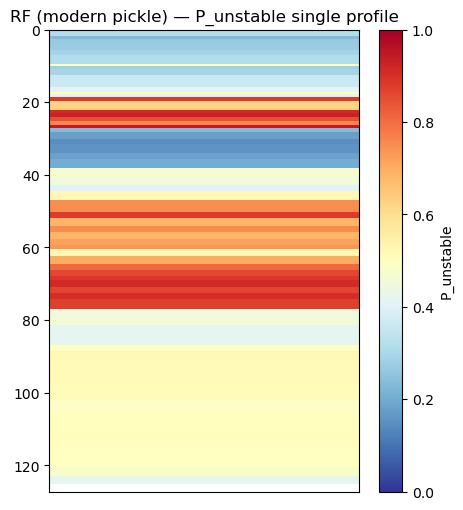

In [ ]:
# RF modern: imports and single-profile run (using existing helper modules)
import importlib, matplotlib.pyplot as plt, pandas as pd, numpy as np, datetime, pathlib

for rf_module_name in ["get_RF", "readProfile", "plt_RF"]:
    importlib.import_module(rf_module_name)

import get_RF, readProfile, plt_RF

# Reload plt_RF to pick up any code changes
importlib.reload(plt_RF)

rf_feature_names = ['viscdefrate', 'rcflat', 'sphericity', 'grainsize', 'penetrationdepth', 'slab_rhogs']


def rf_fix_punstable(df: pd.DataFrame, column: str = 'P_unstable') -> pd.DataFrame:
    """Ensure instability probabilities sit inside [0, 1], with gentle auto-scaling."""
    if column not in df.columns:
        return df
    rf_vals = pd.to_numeric(df[column], errors='coerce')
    rf_valid = rf_vals.dropna()
    if len(rf_valid) == 0:
        print(f"Warning: {column} contains only NaN values.")
        return df
    rf_min = float(rf_valid.min())
    rf_max = float(rf_valid.max())
    if rf_max <= 1.0 + 1e-6 and rf_min >= -1e-6:
        df[column] = rf_vals.clip(0.0, 1.0)
        return df
    if rf_max <= 100.0 and rf_min >= 0.0:
        print("Detected percentage-scale P_unstable; scaling down by 100.")
        df[column] = (rf_vals / 100.0).clip(0.0, 1.0)
        return df
    print(f"Warning: {column} range {rf_min:.3f}–{rf_max:.3f}; clipping to [0, 1].")
    df[column] = rf_vals.clip(0.0, 1.0)
    return df


rf_example_pro = None
rf_example_candidates = [
    pathlib.Path("snowprofiles/WFJ2_2017.pro"),
    pathlib.Path("../input_example/WFJ2_2017.pro"),
    pathlib.Path("input_example/WFJ2_2017.pro"),
]
if 'rf_inst_dir_hint' in globals():
    rf_example_candidates.append(pathlib.Path(rf_inst_dir_hint) / "WFJ2_2017.pro")

for rf_candidate in rf_example_candidates:
    if rf_candidate and rf_candidate.exists():
        rf_example_pro = str(rf_candidate)
        break

if not rf_example_pro:
    print("No example .pro found. Use your own SNOWPACK .pro path below:")
    rf_example_pro = ""

rf_timestamp = datetime.datetime(2017, 2, 1, 11, 0)
rf_slopeangle = 0

if rf_example_pro:
    rf_profile = readProfile.read_profile(rf_example_pro, rf_timestamp, remove_soil=True)
    rf_df_profile = get_RF.create_RFprof(rf_profile, rf_slopeangle, rf_model_modern)
    rf_df_profile = rf_fix_punstable(rf_df_profile)
    rf_p_valid = rf_df_profile['P_unstable'].dropna()
    if len(rf_p_valid) > 0:
        rf_p_min = float(rf_p_valid.min())
        rf_p_max = float(rf_p_valid.max())
        if rf_p_min < -1e-6 or rf_p_max > 1.0 + 1e-6:
            print(f"Warning: P_unstable still outside [0, 1] after normalization: [{rf_p_min:.6f}, {rf_p_max:.6f}]")
            print("Proceeding with clipped values.")
            rf_df_profile['P_unstable'] = rf_df_profile['P_unstable'].clip(0.0, 1.0)
    rf_fig, rf_ax = plt.subplots(figsize=(5, 6))
    plt_RF.plot_sp_single_P0(rf_fig, rf_ax, rf_df_profile, var='P_unstable', colorbar=True)
    rf_ax.set_title("RF (modern pickle) — P_unstable single profile")
    plt.show()
else:
    print("Set `rf_example_pro` to a valid .pro file path in this cell and re-run.")


Reading file:  snowprofiles/WFJ2_2017.pro


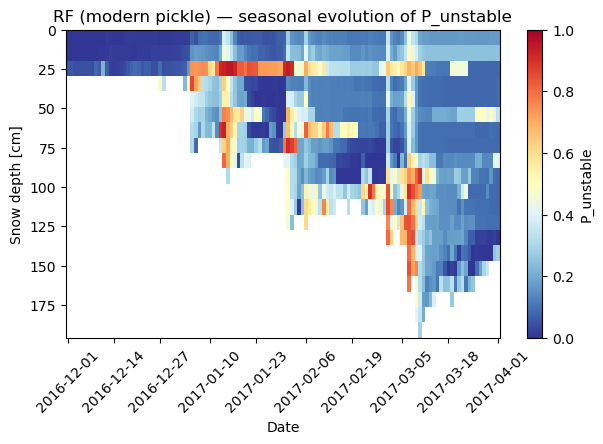

In [ ]:
# RF modern: seasonal evolution (daily), using modern model
rf_year = 2017
rf_start = pd.Timestamp(rf_year - 1, 12, 1, 12, 0)
rf_stop = pd.Timestamp(rf_year, 4, 1, 12, 0)
rf_slopeangle = 0

if rf_example_pro:
    rf_profiles_all = readProfile.read_profile(rf_example_pro, remove_soil=True)
    rf_profiles_data = {}
    if isinstance(rf_profiles_all, dict) and 'data' in rf_profiles_all:
        rf_profiles_data = rf_profiles_all['data']
    elif hasattr(rf_profiles_all, 'get'):
        try:
            rf_profiles_data = rf_profiles_all.get('data', {})
        except Exception:
            rf_profiles_data = {}
    rf_dates = pd.date_range(rf_start, rf_stop, freq='D')
    rf_rows = []
    for rf_ts in rf_dates:
        rf_profile_daily = None
        if isinstance(rf_profiles_data, dict):
            rf_profile_daily = rf_profiles_data.get(rf_ts)
        if rf_profile_daily is None:
            continue
        if not rf_profile_daily or len(rf_profile_daily.get('height', [])) == 0:
            continue
        rf_df_daily = get_RF.create_RFprof(rf_profile_daily, rf_slopeangle, rf_model_modern)
        rf_df_daily = rf_fix_punstable(rf_df_daily)
        if 'layer_top' in rf_df_daily:
            rf_df_daily['HS'] = rf_df_daily['layer_top'].iloc[-1]
        rf_df_daily.insert(0, 'datetime', rf_ts)
        rf_rows.append(rf_df_daily)
    if rf_rows:
        rf_evo = pd.concat(rf_rows, ignore_index=True)
        rf_evo = rf_evo.sort_values(['datetime', 'layer_top']).reset_index(drop=True)
        rf_unique_days = rf_evo['datetime'].nunique()
        if rf_unique_days < 2:
            print(f"Seasonal plot needs ≥2 daily profiles; found {rf_unique_days}. Provide more dates or adjust rf_start/rf_stop.")
        else:
            rf_fig_evo, rf_ax_evo = plt.subplots(figsize=(7, 4))
            plt_RF.plot_evo_SP(rf_evo, rf_fig_evo, rf_ax_evo, rf_start, rf_stop, var='P_unstable', colorbar=True, resolution='D')
            rf_ax_evo.set_title("RF (modern pickle) — seasonal evolution of P_unstable")
            plt.show()
    else:
        print("No profiles found between", rf_start, "and", rf_stop)
else:
    print("Set `rf_example_pro` above and re-run after providing a valid .pro profile.")


In [ ]:
# RF modern: optional — run on your own .pro and export CSV
from IPython.display import display
import pathlib

try:
    from google.colab import drive
    rf_in_colab = True
except Exception:
    rf_in_colab = False

if rf_in_colab:
    drive.mount('/content/drive', force_remount=True)

rf_my_pro_file = ""  # e.g., "/content/drive/MyDrive/SNOWPACK/KEYSTONE_2025.pro"
rf_my_ts = "2025-01-15 11:00"
rf_my_slope = 35
rf_out_csv = (rf_nb_dir / "p_unstable_daily.csv").resolve()

if rf_my_pro_file:
    rf_profiles_custom = readProfile.read_profile(rf_my_pro_file, remove_soil=True)
    rf_profiles_custom_data = {}
    if isinstance(rf_profiles_custom, dict) and 'data' in rf_profiles_custom:
        rf_profiles_custom_data = rf_profiles_custom['data']
    elif hasattr(rf_profiles_custom, 'get'):
        try:
            rf_profiles_custom_data = rf_profiles_custom.get('data', {})
        except Exception:
            rf_profiles_custom_data = {}
    rf_ts = pd.Timestamp(rf_my_ts)
    rf_profile_custom = rf_profiles_custom_data.get(rf_ts)
    if rf_profile_custom is None:
        raise ValueError(f"Timestamp {rf_ts} not found in {rf_my_pro_file}")
    rf_df_custom = get_RF.create_RFprof(rf_profile_custom, rf_my_slope, rf_model_modern)
    rf_df_custom = rf_fix_punstable(rf_df_custom)
    rf_fig_custom, rf_ax_custom = plt.subplots(figsize=(5, 6))
    plt_RF.plot_sp_single_P0(rf_fig_custom, rf_ax_custom, rf_df_custom, var='P_unstable', colorbar=True)
    rf_ax_custom.set_title(f"RF modern — {pathlib.Path(rf_my_pro_file).stem} @ {rf_ts}")
    plt.show()

    rf_start_custom = pd.Timestamp(rf_ts.year - 1, 12, 1, 12, 0)
    rf_stop_custom = pd.Timestamp(rf_ts.year, 4, 1, 12, 0)
    rf_rows_custom = []
    for rf_day in pd.date_range(rf_start_custom, rf_stop_custom, freq='D'):
        rf_profile_day = rf_profiles_custom_data.get(rf_day)
        if not rf_profile_day or len(rf_profile_day.get('height', [])) == 0:
            continue
        rf_df_day = get_RF.create_RFprof(rf_profile_day, rf_my_slope, rf_model_modern)
        rf_df_day = rf_fix_punstable(rf_df_day)
        rf_rows_custom.append({
            'datetime': rf_day,
            'HS': float(rf_df_day['layer_top'].iloc[-1]) if 'layer_top' in rf_df_day else float('nan'),
            'P_unstable_max': float(rf_df_day['P_unstable'].max()),
            'z_Pmax': float(rf_df_day.loc[rf_df_day['P_unstable'].idxmax(), 'layer_top']) if 'layer_top' in rf_df_day else float('nan')
        })
    if rf_rows_custom:
        rf_out_df = pd.DataFrame(rf_rows_custom).sort_values('datetime')
        rf_out_df.to_csv(rf_out_csv, index=False)
        display(rf_out_df.head())
        print("Wrote:", rf_out_csv)
    else:
        print("No daily profiles found for export between", rf_start_custom, "and", rf_stop_custom)
else:
    print("To analyze your own file, set `rf_my_pro_file` above and re-run.")


To analyze your own file, set `rf_my_pro_file` above and re-run.


### Notes

- If unpickling fails, upload another `.sav` from the CRAN `inst/python` folder (or your own source) into `rf_instability_modern/inst_python`, or temporarily pin scikit-learn to a version that matches the available filenames before retrying.
- You can mount external storage and set `rf_model_path` manually before re-running the selection cell when working offline or without download access.
- `P_unstable` continues to indicate layer-wise instability probability; combine it with field observations before acting on results.
- `rf_slopeangle` only steers the MF-crust penetration-depth heuristic and does not change the underlying trained model.
